# Fine-Tuning ChemBERTa for Regression

Different learning rates, number of epochs, and batch sizes were explored

In [5]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM, pipeline, RobertaModel, RobertaTokenizer
from tqdm import tqdm
import torch.nn as nn

In [2]:
# Load the dataset
df = pd.read_csv("data/qm9_recommended_data.csv")
print(f'Number of examples is: {len(df)}')
df.head()

Number of examples is: 133055


,PBE_TZP,B3LYP(VWN5)_TZP,GFNXTB,M06-2X_TZP,smiles,chemformula,index
0,-18.261372,-19.140565,-21.979934,-19.987828,[H]C([H])([H])[H],CH4,1
1,-12.975380,-12.896428,-17.405808,-12.694483,[H]N([H])[H],H3N,2
2,-10.370616,-11.226953,-14.033122,-12.538535,[H]O[H],H2O,3
3,-18.070231,-19.266542,-22.665365,-21.246587,[H]C#C[H],C2H2,4
4,-14.127323,-14.386552,-19.345571,-15.292001,[H]C#N,CHN,5


In [6]:
# Load the pre-trained model and tokenizer
model_name = "DeepChem/ChemBERTa-77M-MLM"
model = AutoModelForMaskedLM.from_pretrained(model_name, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(model_name)

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

# Determine the maximum sequence length
max_length = tokenizer.model_max_length
print(max_length)

Device set to use cuda:0


512


# Test the tokenizer

In [8]:
print(f"Mask token: {tokenizer.mask_token}")

Mask token: [MASK]


In [9]:
# Test model on predicting a masked token/character within the SMILES molecule for benzene. 
smiles_mask = "C1=CC=CC[MASK]C1"
smiles = "C1=CC=CC=C1"

masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
  print(smi)

{'score': 0.8796958327293396, 'token': 22, 'token_str': '=', 'sequence': 'C1=CC=CC=C1'}
{'score': 0.07391984015703201, 'token': 16, 'token_str': 'C', 'sequence': 'C1=CC=CCCC1'}
{'score': 0.021330077201128006, 'token': 17, 'token_str': '(', 'sequence': 'C1=CC=CC(C1'}
{'score': 0.014612941071391106, 'token': 21, 'token_str': '2', 'sequence': 'C1=CC=CC2C1'}
{'score': 0.004343654494732618, 'token': 38, 'token_str': '#', 'sequence': 'C1=CC=CC#C1'}


In [10]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image


def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset):    
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

# Test the transformer model (model uses mask)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNor

In [16]:
# Your sequence
sequence = f"C1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

# Tokenize and move input to the same device as model
input = tokenizer.encode(sequence, return_tensors="pt").to(device)

# Locate [MASK] token
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

# Run model
with torch.no_grad():
    token_logits = model(input)[0]

# Get top predictions for the mask token
mask_token_logits = token_logits[0, mask_token_index, :]
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    smi = sequence.replace(tokenizer.mask_token, tokenizer.decode([token]))
    print(smi)
    smi_mol = get_mol(smi)
    substructure_mol = get_mol(substructure)
    if smi_mol is None:  # if the predicted SMILES is invalid
        continue
    Draw.MolToFile(smi_mol, smi + ".png")
    matches = find_matches_one(smi_mol, substructure_mol)
    atomset = list(matches[0])
    img = get_image(smi_mol, atomset)
    img.format = "PNG"
    image_list.append(img)


C1=CC=CC=C1
C1=CC=CC=N1
C1=CC=CC=S1
C1=CC=CC=P1
C1=CC=CC=c1


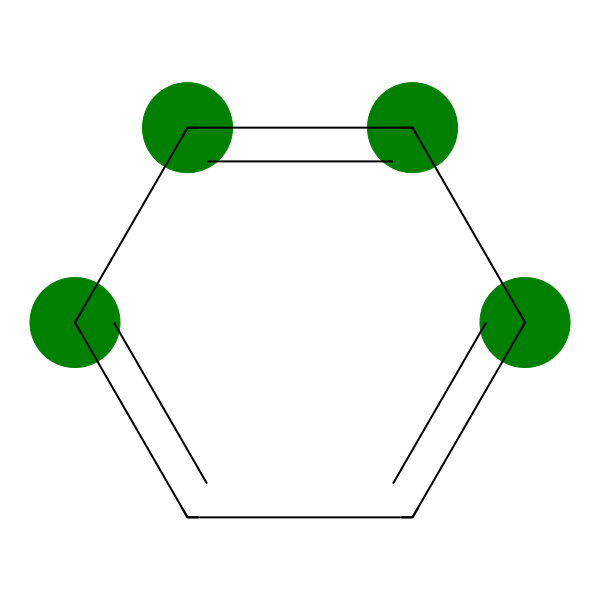

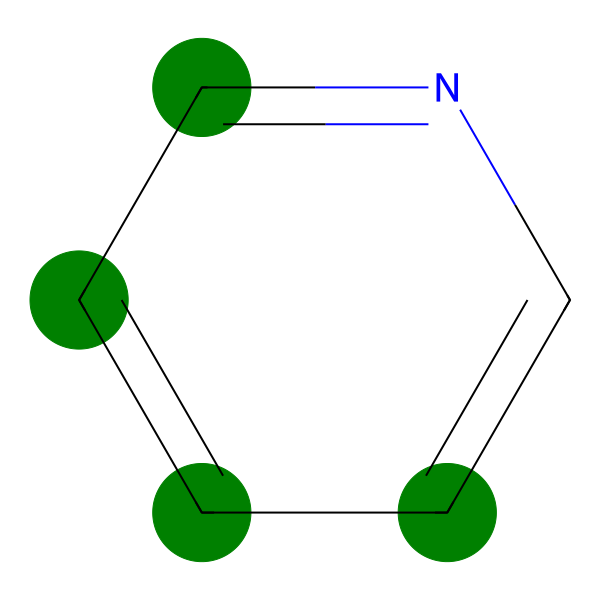

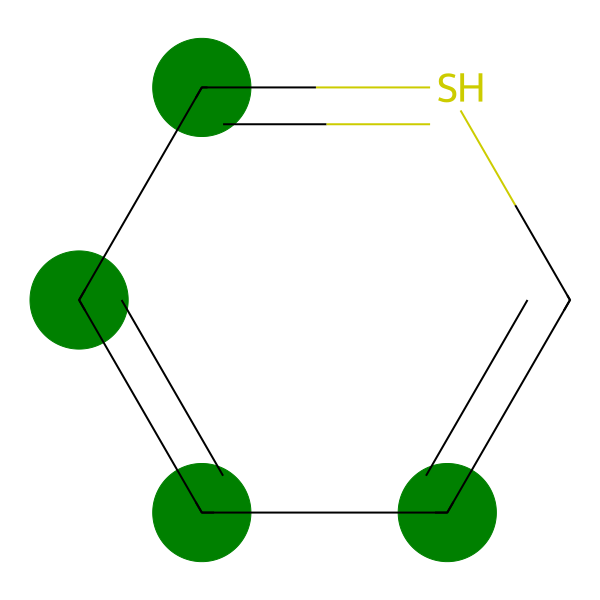

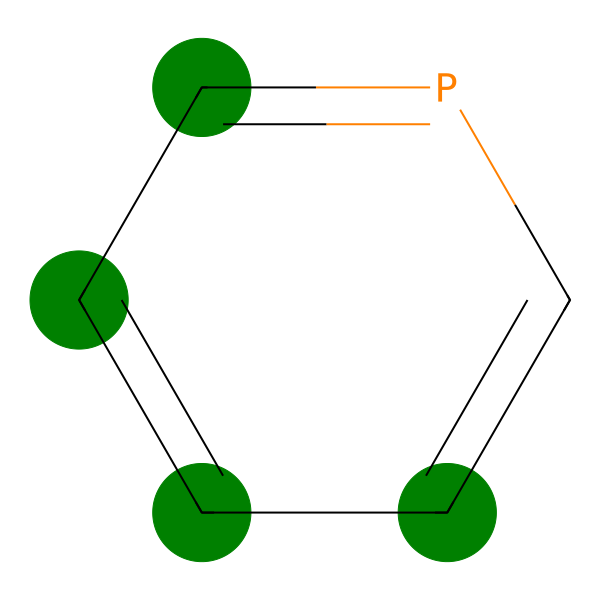

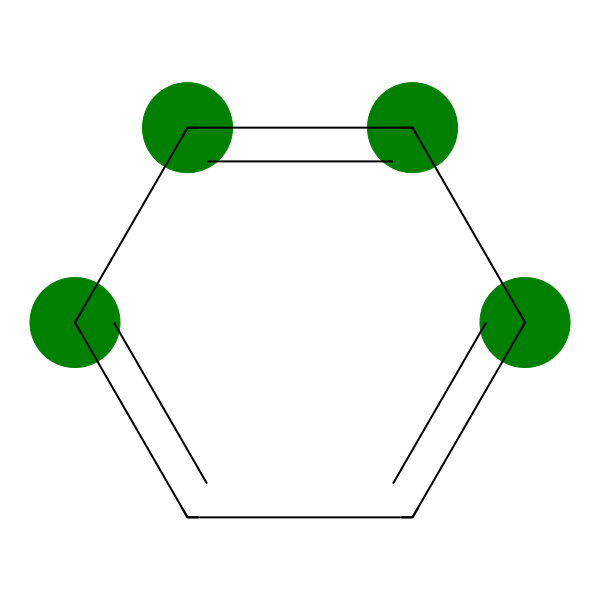

In [17]:
from IPython.display import Image 

for img in image_list:
  display(img)

# Visualizing the Attention Mechanism in ChemBERTa using BertViz

In [18]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

## Smiles-Tokenizer Attention by Head View

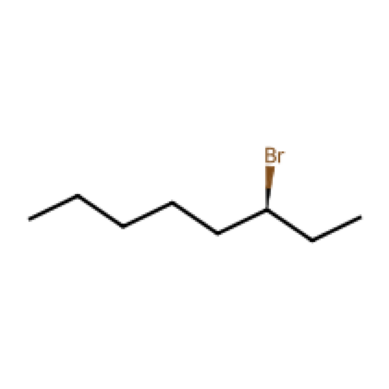

In [20]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

m = Chem.MolFromSmiles('CCCCC[C@@H](Br)CC')

# Draw molecule using RDKit and matplotlib
img = Draw.MolToImage(m, size=(200, 200))
plt.imshow(img)
plt.axis('off')
plt.show()


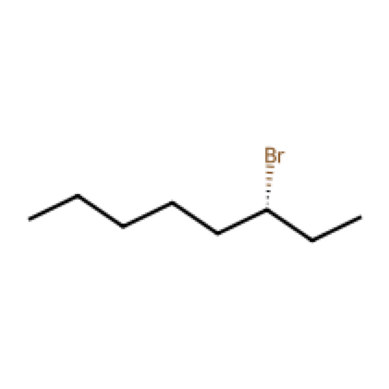

In [21]:
m = Chem.MolFromSmiles('CCCCC[C@H](Br)CC')

# Draw molecule using RDKit and matplotlib
img = Draw.MolToImage(m, size=(200, 200))
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
from transformers import RobertaModel, RobertaTokenizer
from bertviz import head_view

model_version = 'seyonec/PubChem10M_SMILES_BPE_450k'
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

call_html()

head_view(attention, tokens)

RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>